# Spectral Diffusion for a Toy ${\rm SU}(3)$ Model using Group-Valued Score Matching

In this notebook, we apply the same machinery we used in the other notebook (where we trained a score network to learn the heat kernel and denoise the variance-expanding diffusion process) to learn a toy theory involving a single ${\rm SU}(3)$ matrix $U$ (one independent eigenangle $\theta$).

## Setup

In [1]:
import math
import torch
import numpy as np

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import sun_diffusion
import sun_diffusion.analysis as al  # analysis library

from sun_diffusion.action import SUNToyPolynomialAction
from sun_diffusion.sun import (
    mat_angle, adjoint,
    extract_diag, embed_diag,
    random_sun_element, random_un_haar_element,
)
from sun_diffusion.diffusion import VarianceExpandingDiffusionSUN, PowerDiffusionSUN
from sun_diffusion.heat import sun_score_hk
from sun_diffusion.utils import grab, compute_ess, compute_kl_div

In [3]:
from sun_diffusion.devices import get_device, get_dtype, set_device, summary
set_device('cuda', 3)
print(summary())

Using device: cuda:3 (NVIDIA GH200 120GB) with dtype: torch.float32


## Define a Target Theory and Generate Training Data

The target theory whose distribution we will try to reproduce is specified by a toy action of our choosing, which we define to be 
$$S_i(U) = -\frac{\beta}{2} {\rm Re}{\rm Tr}\left[\sum_n c_n U^n\right].$$

In [4]:
Nc = 3
beta = 9.0
coeffs_dict = {
    0: [1.0, 0., 0.],
    1: [0.17, -0.65, 1.22],
    2: [0.98, -0.63, -0.21]
}  # from Table I of [2008.05456]

coeffs = 1  # change this to try other coefficient sets
action = SUNToyPolynomialAction(beta, coeffs_dict[coeffs])

To generate configurations, we will use the Metropolis algorithm for simplicity.

In [5]:
def apply_metropolis(batch_size, Nc, action, num_therm, num_iters, step_size, save_freq=10):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    U = random_sun_element(batch_size, Nc=Nc)
    ens = []
    for i in tqdm.tqdm(range(-num_therm, num_iters)):
        # Proposal
        V = random_sun_element(batch_size, Nc=Nc, scale=step_size)
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand(batch_size)  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))
        if i >= 0 and (i+1) % save_freq == 0:
            ens.append(U)
    return torch.cat(ens), action_vals, accept_rates

In [6]:
# Generate samples
batch_size = 16
num_therm = 1_000
num_iters = 10_240
save_freq = 10
step_size = 0.4

num_train = batch_size * (num_iters // save_freq)
print(f'{num_train=}')

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = batch_size,
    Nc = Nc,
    action = action,
    num_therm = num_therm,
    num_iters = num_iters,
    step_size = step_size
)
print('U_train shape:', U_train.shape)

num_train=16384


  0%|          | 0/11240 [00:00<?, ?it/s]

U_train shape: torch.Size([16384, 3, 3])


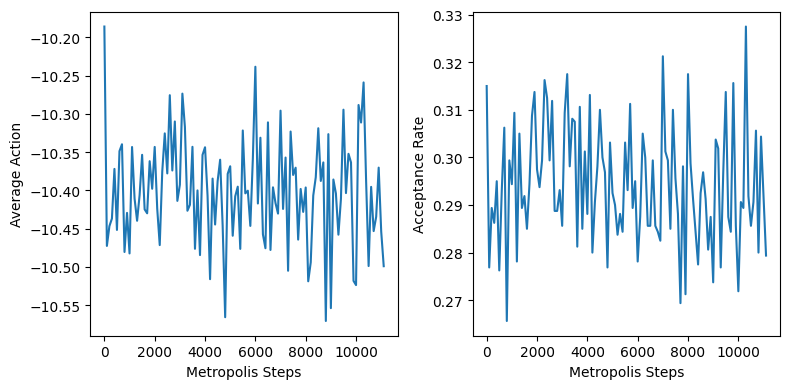

In [7]:
# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(*al.bin_data(action_vals, binsize=100))
axes[0].set_ylabel('Average Action')

axes[1].plot(*al.bin_data(accept_rates, binsize=100))
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
plt.show()

In [8]:
# Helper funcs for plotting SU(3) spectral densities
from sun_diffusion.heat import _sun_hk_meas_D, _sun_hk_meas_J

def log_meas(thetas):
    Nc = thetas.shape[-1]
    delta = torch.stack([
        thetas[..., i] - thetas[..., j]
        for i in range(Nc) for j in range(i+1, Nc)
    ], dim=-1)
    
    logJ = torch.sum(
        _sun_hk_meas_D(delta).abs().log() +
        _sun_hk_meas_J(delta).abs().log(),
    dim=-1)
    return logJ


# All 6 Weyl permutations for SU(3)
_SU3_WYL_PERMS = torch.tensor([
    [0, 1, 2],
    [1, 0, 2],
    [0, 2, 1],
    [2, 0, 1],
    [1, 2, 0],
    [2, 1, 0],
])

def random_weyl_permute(thetas, eigvecs=None):
    batch_shape = thetas.shape[:-1]
    n_batch = thetas.numel() // 3

    # flatten batch
    thetas_flat = thetas.reshape(n_batch, 3)
    if eigvecs is not None:
        eigvecs_flat = eigvecs.reshape(n_batch, 3, 3)

    # random perms for each batch element
    idx = torch.randint(0, 6, (n_batch,))
    perms = _SU3_WYL_PERMS[idx]  # shape (n_batch, 3)

    # apply permutation to eigenangles
    thetas_perm = torch.stack([thetas_flat[i, perms[i]] for i in range(n_batch)], dim=0)
    if eigvecs is not None:
        # apply same permutation to columns of eigenvectors
        eigvecs_perm = torch.stack([eigvecs_flat[i, :, perms[i]] for i in range(n_batch)], dim=0)
        thetas_perm = thetas_perm.reshape(*batch_shape, 3)
        eigvecs_perm = eigvecs_perm.reshape(*eigvecs.shape)
        return thetas_perm, eigvecs_perm
    return thetas_perm.reshape(*batch_shape, 3)

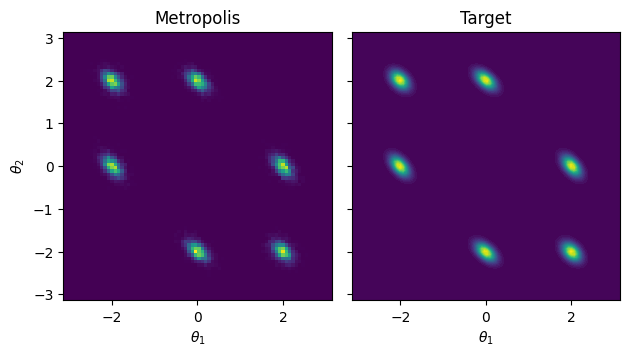

In [9]:
hist_range = [[-np.pi, np.pi], [-np.pi, np.pi]]

grid = 100
th1 = torch.linspace(-np.pi, np.pi, grid)
th2 = torch.linspace(-np.pi, np.pi, grid)
theta1, theta2 = torch.meshgrid(th1, th2, indexing='ij')
theta3 = - (theta1 + theta2)
thetas = torch.stack([theta1, theta2, theta3], dim=-1)  # [grid, grid, 3]

fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].set_ylabel(r'$\theta_2$')
for ax in axes:
    ax.set_xlabel(r'$\theta_1$')
    ax.set_aspect(1.0)

# Metropolis samples
x_train, _, _ = mat_angle(U_train)
x_train = random_weyl_permute(x_train)  # random permutations for Weyl symmetry
x_train = grab(x_train)
axes[0].set_title('Metropolis')
axes[0].hist2d(x_train[:, 0], x_train[:, 1], bins=80, density=True, range=hist_range)

# Target density
axes[1].set_title('Target')
log_haar = log_meas(thetas)  # for plots w.r.t. Lebesgue measure
logp = -action.value_eigs(thetas)
logp -= logp.max()  # for stability
p_target = torch.exp(logp + log_haar)
axes[1].contourf(grab(theta1), grab(theta2), grab(p_target), levels=40, cmap='viridis')

fig.tight_layout()
fig.show()

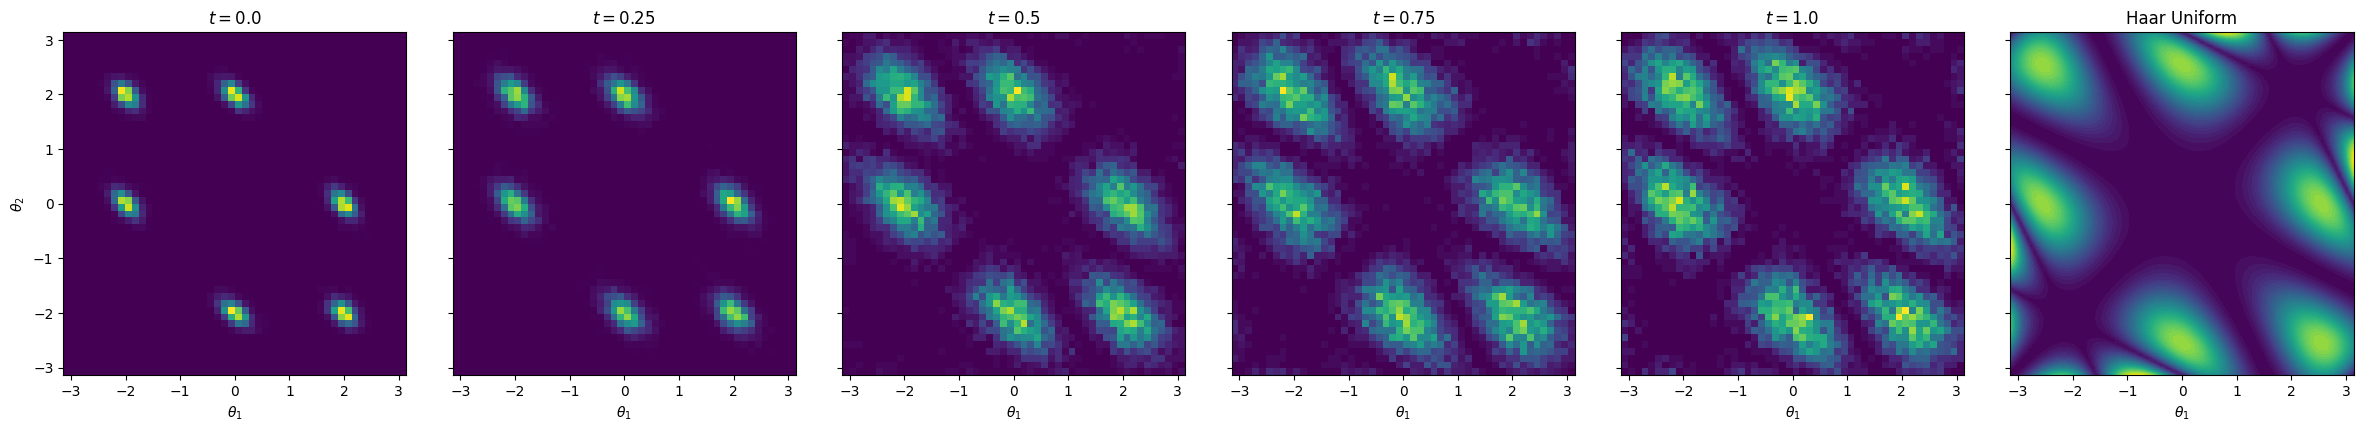

In [10]:
diffuser = PowerDiffusionSUN(kappa=3.0, alpha=1.0)
times = [0.0, 0.25, 0.5, 0.75, 1.0]

hist_range = [[-np.pi, np.pi], [-np.pi, np.pi]]
fig, axes = plt.subplots(1, len(times) + 1, sharey=True, figsize=(4*len(times) + 4, 4))
axes[0].set_ylabel(r'$\theta_2$')
for ax in axes:
    ax.set_xlabel(r'$\theta_1$')
    ax.set_aspect(1.0)

# Diffused histograms
U_0 = U_train.clone()#[::10]
for t, ax in zip(times, axes[:-1]):
    if t == 0:  # avoid sampling from HK at t=0
        x_t, _, _ = mat_angle(U_0)
    else:
        U_t, _, _ = diffuser.diffuse(U_0, t*torch.ones(U_0.size(0)), n_iter=15)
        x_t, _, _ = mat_angle(U_t)
    x_t = random_weyl_permute(x_t)
    ax.hist2d(grab(x_t[:, 0]), grab(x_t[:, 1]), bins=50, density=True, range=hist_range)
    ax.set_title(f'$t = {t}$')

# Haar Uniform density
p_haar = torch.exp(log_haar)
axes[-1].contourf(grab(theta1), grab(theta2), grab(p_haar), levels=40, cmap='viridis')
axes[-1].set_title('Haar Uniform')

fig.tight_layout()
fig.show()

## Train a Score Network

Now we must construct a score network that will take as input the eigenangle $\theta$ and time $t$.

In [11]:
class SU3ScoreNet(torch.nn.Module):
    def __init__(self, input_dim=4, hidden_dim=8):
        super().__init__()
        self.nk = (input_dim - 1)//2
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 2))
        
    def forward(self, x_t, t):
        assert len(x_t.shape) == 2, \
            'input eigenangles shape should be [batch_size, Nc-1]'
        assert len(t.shape) == 1, \
            'times should only have a batch dimension'
        cos_t = torch.cos(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        sin_t = torch.sin(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        inp = torch.cat([x_t, cos_t, sin_t], dim=-1)
        return self.net(inp) * torch.sin(x_t) # enforce score -> 0 at endpoints


def _test_su3_score_net():
    batch_size = 10
    Nc = 3
    
    x1 = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    x2 = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    x = torch.cat([x1, x2], dim=-1)
    print('x shape:', x.shape)
    t = torch.rand((batch_size,))
    s_t = SU3ScoreNet(input_dim=6)(x, t)
    print('score shape:', s_t.shape)

    assert s_t.shape == x.shape, \
        '[FAILED: score net output must have same shape as input data]'
    print('[PASSED]')

_test_su3_score_net()

x shape: torch.Size([10, 2])
score shape: torch.Size([10, 2])
[PASSED]


Define the loss function

In [12]:
def score_matching_loss_sun(U_0, diffuser, score_net, tol=1e-3):
    batch_size = U_0.size(0)
    t = tol + (1 - tol) * torch.rand(batch_size)
    sigma_t = diffuser.sigma_func(t)

    U_t, xs, V = diffuser.diffuse(U_0, t, n_iter=25)
    x_t, P, Pinv = mat_angle(U_t)

    # Random permutation so score net seels all Weyl chambers
    x_t, P = random_weyl_permute(x_t, P)
    Pinv = adjoint(P)

    score = score_net(x_t[..., :-1], t)
    # NOTE(gkanwar): Passing xs instead of (x_t - x_0) is important here
    true_score_xs = sun_score_hk(xs[..., :-1], width=sigma_t)
    true_score = extract_diag(Pinv @ V @ embed_diag(true_score_xs).to(V) @ adjoint(V) @ P).real[...,:-1]

    # NOTE(gkanwar): Scaling by sigma_t^2 results in a roughly constant variance,
    # making training much more stable.
    diff = score - true_score
    loss = torch.mean(sigma_t[:, None]**2 * diff**2)
    return loss

Do the training

In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Make diffusion process
kappa = 3.0
alpha = 1.0
diffuser = PowerDiffusionSUN(kappa, alpha)
#diffuser = VarianceExpandingDiffusionSUN(kappa)

score_net = SU3ScoreNet(input_dim=52, hidden_dim=64)

# Setup training hyperparams
epochs = 100
lr = 1e-2
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Prepare dataloader
batch_size = 3072
dataset = TensorDataset(U_train) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=get_device()))

# Training loop
losses = []
score_net.train()
for epoch in tqdm.tqdm(range(epochs)):
    total_loss = 0.0
    for batch_idx, (U_0_batch,) in enumerate(tqdm.tqdm(dataloader, leave=False)):
        optimizer.zero_grad()
        loss = score_matching_loss_sun(U_0_batch, diffuser, score_net)
        torch.nn.utils.clip_grad_norm_(score_net.parameters(), max_norm=10.0)
        loss.backward()
        optimizer.step()
        total_loss += grab(loss)
        losses.append(grab(loss))
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch}/{epochs} | Loss = {avg_loss:.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0/100 | Loss = 0.279570


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/100 | Loss = 0.279909


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/100 | Loss = 0.277546


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/100 | Loss = 0.277654


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/100 | Loss = 0.283641


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/100 | Loss = 0.275308


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/100 | Loss = 0.281165


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/100 | Loss = 0.271177


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/100 | Loss = 0.277528


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/100 | Loss = 0.277439


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/100 | Loss = 0.272963


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/100 | Loss = 0.268611


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/100 | Loss = 0.265723


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/100 | Loss = 0.258710


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/100 | Loss = 0.253092


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/100 | Loss = 0.249176


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/100 | Loss = 0.246597


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/100 | Loss = 0.246116


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/100 | Loss = 0.243252


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/100 | Loss = 0.244437


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/100 | Loss = 0.246410


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21/100 | Loss = 0.240453


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22/100 | Loss = 0.238357


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23/100 | Loss = 0.237853


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24/100 | Loss = 0.238855


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25/100 | Loss = 0.244217


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26/100 | Loss = 0.243331


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27/100 | Loss = 0.241228


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28/100 | Loss = 0.238701


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29/100 | Loss = 0.232258


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30/100 | Loss = 0.228609


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31/100 | Loss = 0.234459


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32/100 | Loss = 0.235762


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33/100 | Loss = 0.232014


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34/100 | Loss = 0.233117


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35/100 | Loss = 0.228863


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36/100 | Loss = 0.229748


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37/100 | Loss = 0.234366


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38/100 | Loss = 0.236379


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39/100 | Loss = 0.234466


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40/100 | Loss = 0.223927


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41/100 | Loss = 0.217698


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42/100 | Loss = 0.219599


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43/100 | Loss = 0.210491


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44/100 | Loss = 0.215826


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45/100 | Loss = 0.209906


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46/100 | Loss = 0.209880


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47/100 | Loss = 0.212289


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48/100 | Loss = 0.208987


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49/100 | Loss = 0.205489


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50/100 | Loss = 0.215298


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 51/100 | Loss = 0.209307


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 52/100 | Loss = 0.202227


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 53/100 | Loss = 0.204703


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 54/100 | Loss = 0.202202


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 55/100 | Loss = 0.206695


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 56/100 | Loss = 0.201542


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 57/100 | Loss = 0.200536


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 58/100 | Loss = 0.203431


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 59/100 | Loss = 0.202112


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 60/100 | Loss = 0.210319


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 61/100 | Loss = 0.203118


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 62/100 | Loss = 0.207935


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 63/100 | Loss = 0.207332


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 64/100 | Loss = 0.204224


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 65/100 | Loss = 0.204024


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 66/100 | Loss = 0.205350


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 67/100 | Loss = 0.208294


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 68/100 | Loss = 0.209382


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 69/100 | Loss = 0.207505


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 70/100 | Loss = 0.205582


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 71/100 | Loss = 0.205313


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 72/100 | Loss = 0.196760


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 73/100 | Loss = 0.210566


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 74/100 | Loss = 0.204730


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 75/100 | Loss = 0.205777


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 76/100 | Loss = 0.206536


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 77/100 | Loss = 0.203246


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 78/100 | Loss = 0.206531


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 79/100 | Loss = 0.205964


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 80/100 | Loss = 0.197983


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 81/100 | Loss = 0.207465


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 82/100 | Loss = 0.209708


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 83/100 | Loss = 0.207665


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 84/100 | Loss = 0.201329


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 85/100 | Loss = 0.205531


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 86/100 | Loss = 0.206243


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 87/100 | Loss = 0.198072


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 88/100 | Loss = 0.199534


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 89/100 | Loss = 0.209489


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 90/100 | Loss = 0.201272


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 91/100 | Loss = 0.204635


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 92/100 | Loss = 0.200054


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 93/100 | Loss = 0.197673


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 94/100 | Loss = 0.206180


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 95/100 | Loss = 0.202667


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 96/100 | Loss = 0.200730


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 97/100 | Loss = 0.203026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 98/100 | Loss = 0.205746


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 99/100 | Loss = 0.205795


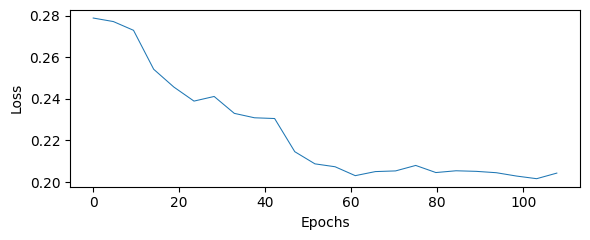

In [14]:
# Plot training loss vs epochs
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
xs, ys = al.bin_data(losses, binsize=25)
xs = xs / (num_train/batch_size) # convert to epochs
ax.plot(xs, ys, lw=0.75)
fig.set_tight_layout(True)
plt.show()

## Denoising Process

Now we run the reverse process to generate new samples.

In [15]:
def sample_sun_gaussian(shape):
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))

In [16]:
def log_haar_su3(x):
    """
    Computes log Haar density for SU(3) using the 2 independent eigenangles.
    x: tensor of shape [batch_size, 2], containing angles theta1, theta2
    """
    theta1 = x[:, 0]
    theta2 = x[:, 1]

    term1 = torch.log(torch.abs(torch.sin((theta1 - theta2)/2))**2)
    term2 = torch.log(torch.abs(torch.sin((2*theta1 + theta2)/2))**2)
    term3 = torch.log(torch.abs(torch.sin((theta1 + 2*theta2)/2))**2)

    log_haar = term1 + term2 + term3

    # Approximate normalization constant for SU(3)
    log_norm = math.log((2 * math.pi)**2 / 3)  # optional, depends on your usage
    return log_haar - log_norm

In [17]:
@torch.no_grad()
def solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=False):
    trajectories = {
        'U_t': [],
        'logp': [],
        'logq': [],
        'kl_div': [],
        'ess': [],
        't': [],
        'Z': [],
    }
    dt = 1 / num_steps
    t = 1.0
    batch_size = U_1.size(0)
    
    U_t = U_1.clone()
    logJ = 0.
    for step in tqdm.tqdm(range(num_steps)):
        x_t, V, V_inv = mat_angle(U_t)
        
        # Get ODE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((batch_size,)))
        jac = torch.func.vmap(torch.func.jacfwd(lambda x: score_net(x[None], torch.tensor(t)[None])[0]))(x_t[..., :-1])
        div = torch.einsum('...ii->...', jac)
        
        # Integration step in reverse time
        score = torch.cat([score, -score.sum(-1, keepdim=True)], dim=-1)
        x_t = x_t + 0.5 * g_t**2 * score * dt
        logJ = logJ + 0.5 * g_t**2 * div * dt

        # Eigen-recomposition
        D = embed_diag(torch.exp(1j * x_t)).to(V)
        U_t = V @ D @ V_inv
        t -= dt

        # Collect and print metrics
        logp = -action(U_t) + log_meas(x_t)
        logq = logr - logJ
        Z = al.bootstrap(grab((logp - logq).exp()), Nboot=1000, f=al.rmean)
        kl_div = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_kl_div)
        ess = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_ess)
        if verbose and step % 20 == 0:
            print(f'Step {step}/{num_steps}')
            print('logp =', logp.mean().item())
            print('logq =', logq.mean().item())
            print('Dkl =', kl_div)
            print('ESS =', ess)
            print()
        trajectories['t'].append(t)
        trajectories['U_t'].append(grab(U_t))
        trajectories['logp'].append(al.bootstrap(grab(logp), Nboot=1000, f=al.rmean))
        trajectories['logq'].append(al.bootstrap(grab(logq), Nboot=1000, f=al.rmean))
        trajectories['kl_div'].append(kl_div)
        trajectories['ess'].append(ess)
        trajectories['Z'].append(Z)

    for key in ['Z', 'kl_div', 'ess', 'logp', 'logq']:
        trajectories[key] = np.stack(trajectories[key], axis=1)
    
    return U_t, logJ, trajectories

In [18]:
#num_samples = batch_size
num_samples = 4096
Nc = 3
U_1 = random_un_haar_element(num_samples, Nc=Nc)
U_1 *= (torch.linalg.det(U_1)**(-1/Nc) * torch.exp(2j*np.pi*torch.randint(Nc, size=(num_samples,))/Nc))[...,None,None]

In [19]:
# Get prior log likelihood
x_1, _, _ = mat_angle(U_1)
logr = log_meas(x_1)
print('avg logr =', logr.mean().item())
print('std logr =', logr.std().item())

avg logr = 3.857907295227051
std logr = 1.06230890750885


In [20]:
U_0, logJ, history = solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=True)
x_0, _, _ = mat_angle(U_0)

  0%|          | 0/200 [00:00<?, ?it/s]

Step 0/200
logp = 7.535633087158203
logq = 3.858407497406006
Dkl = (-3.6780179, 0.07548857)
ESS = (0.14065932932329087, 0.00424060513157021)

Step 20/200
logp = 7.581127166748047
logq = 3.861954689025879
Dkl = (-3.7197037, 0.07739922)
ESS = (0.14202507586770377, 0.004271178094946753)

Step 40/200
logp = 7.640702247619629
logq = 3.86688232421875
Dkl = (-3.7685273, 0.074074835)
ESS = (0.14372002348429713, 0.0043458873125101615)

Step 60/200
logp = 7.8219757080078125
logq = 3.8889660835266113
Dkl = (-3.9319391, 0.07687496)
ESS = (0.14988957107483156, 0.004418217737662793)

Step 80/200
logp = 8.257875442504883
logq = 3.9501571655273438
Dkl = (-4.3038244, 0.07196925)
ESS = (0.16458545136692998, 0.0045813734526286625)

Step 100/200
logp = 9.137491226196289
logq = 4.100302696228027
Dkl = (-5.035174, 0.066610925)
ESS = (0.20263236996204848, 0.004796829442179948)

Step 120/200
logp = 10.440691947937012
logq = 4.374892711639404
Dkl = (-6.066438, 0.0571143)
ESS = (0.28856220911141545, 0.005321392

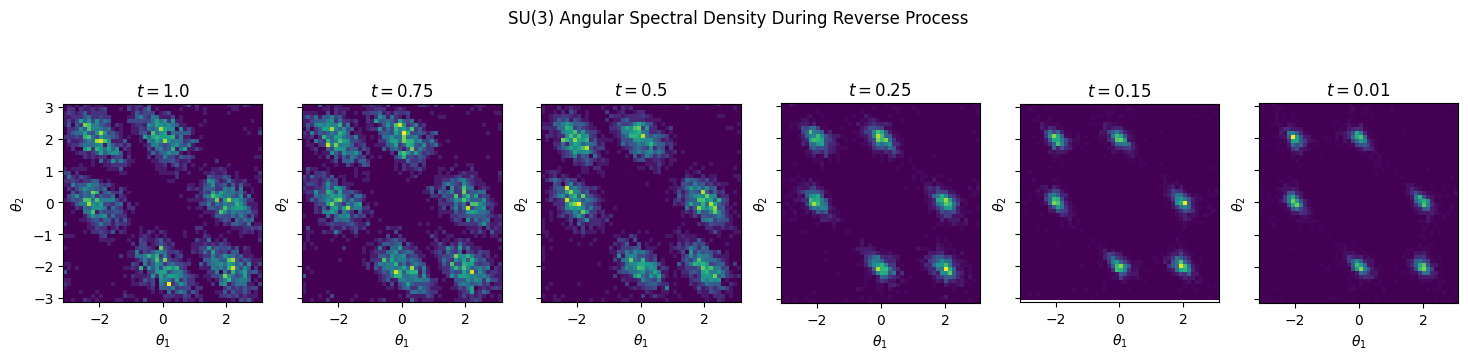

In [21]:
# Plot reverse trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.01]
fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 4), sharey=True)
fig.suptitle('SU(3) Angular Spectral Density During Reverse Process')
for t, ax in zip(times, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(history['U_t']))
    U_t = torch.tensor(history['U_t'][step])
    x_t, _, _ = mat_angle(U_t)
    x_t = random_weyl_permute(x_t)
    ax.hist2d(grab(x_t[:, 0]), grab(x_t[:, 1]), bins=50, density=True)
    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_aspect(1.0)
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

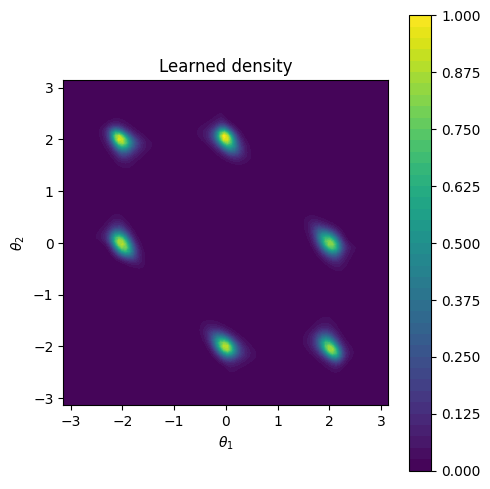

In [23]:
grid = 100
theta1 = torch.linspace(-np.pi, np.pi, grid)
theta2 = torch.linspace(-np.pi, np.pi, grid)
Theta1, Theta2 = torch.meshgrid(theta1, theta2, indexing="ij")

Theta3 = -Theta1 - Theta2
thetas = torch.stack([Theta1, Theta2, Theta3], dim=-1)  # [grid, grid, 3]

@torch.no_grad()
def reconstruct_logq_from_score(score_net, thetas, ti=0.0, num_steps=200):
    """compute logq integrating score ODE from ti -> 1"""
    assert len(thetas.shape) == 2, 'thetas must have shape (bs, Nc)'
    batch_size = thetas.shape[0]
    logJ = torch.zeros_like(thetas[...,0])
    dt = (1-ti)/num_steps
    t = ti
    x_t = thetas
    for step in tqdm.tqdm(range(num_steps)):
        # Get ODE params
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((batch_size,)))
        jac = torch.func.vmap(torch.func.jacfwd(lambda x: score_net(x[None], torch.tensor(t)[None])[0]))(x_t[..., :-1])
        div = torch.einsum('...ii->...', jac)

        # Integration step in reverse time
        score = torch.cat([score, -score.sum(-1, keepdim=True)], dim=-1)
        x_t = x_t - 0.5 * g_t**2 * score * dt
        logJ = logJ + 0.5 * g_t**2 * div * dt

        t += dt
    assert np.isclose(t, 1.0)
    logr = log_haar_su3(x_t)
    #logr = log_meas(x_t)
    return logr - logJ

thetas_flat = thetas.reshape(-1, thetas.shape[-1])
logq = reconstruct_logq_from_score(score_net, thetas_flat, ti=0.0, num_steps=200)
logq = logq.reshape((grid, grid))
logq -= logq.max()

plt.figure(figsize=(5,5))
plt.contourf(
    grab(Theta1),
    grab(Theta2),
    grab(logq.exp()),
    levels=40,
    cmap='viridis'
)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.gca().set_aspect('equal')
plt.title('Learned density')
plt.colorbar()
plt.tight_layout()
plt.show()

In [24]:
def _measure_Z():
    th = torch.linspace(-np.pi, np.pi, steps=501)
    x = torch.stack([th, -th], axis=-1)
    U = embed_diag((1j*x).exp())
    est_Z = grab((th[1]-th[0])*(-action(U) + log_haar_su3(x)).exp().sum())
    return est_Z
true_Z = _measure_Z()

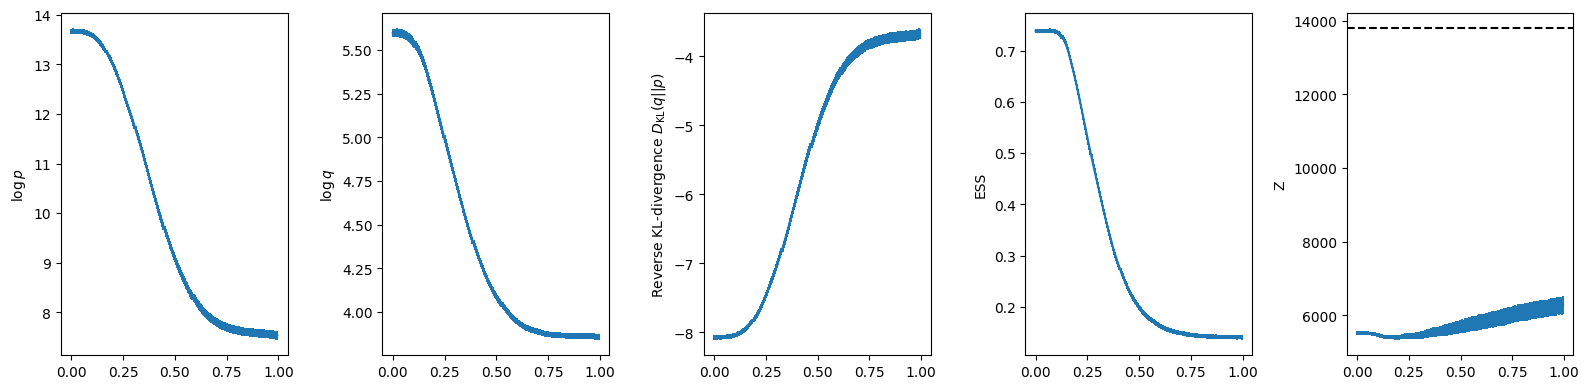

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].errorbar(history['t'], history['logp'][0], yerr=history['logp'][1])
axes[0].set_ylabel(r'$\log p$')

axes[1].errorbar(history['t'], history['logq'][0], yerr=history['logq'][1])
axes[1].set_ylabel(r'$\log q$')

axes[2].errorbar(history['t'], history['kl_div'][0], yerr=history['kl_div'][1])
axes[2].set_ylabel(r'Reverse KL-divergence $D_{\rm KL}(q || p)$')

axes[3].errorbar(history['t'], history['ess'][0], yerr=history['ess'][1])
axes[3].set_ylabel('ESS')

axes[4].errorbar(history['t'], history['Z'][0], yerr=history['Z'][1])
axes[4].axhline(true_Z, color='k', linestyle='--')
axes[4].set_ylabel('Z')

fig.tight_layout()
plt.show()

In [26]:
# Model likelihood
logq = logr - logJ
print('avg logq =', logq.mean().item())
print('std logq =', logq.std().item())

avg logq = 5.597090244293213
std logq = 1.5666061639785767


In [27]:
# Target likelihood
logp = -action(U_0) + log_haar_su3(x_0)
print('avg logp =', logp.mean().item())
print('std logp =', logp.std().item())

avg logp = 5.768993377685547
std logp = 3.345749616622925


In [28]:
# Effective Sample Size
print('ESS =', compute_ess(logp, logq))

ESS = 0.6797746487296839
